# COLLABORATIVE RS

In [1]:
#disabe annoying warnings
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from lightfm import LightFM
from lightfm.data import Dataset
from lightfm.evaluation import precision_at_k, recall_at_k, auc_score, reciprocal_rank
from scipy.sparse import coo_matrix
import numpy as np
import joblib 
from tqdm import tqdm 
import matplotlib.pyplot as plt
from dvclive import Live 

In [5]:
file_path = '/Users/giulia/Desktop/tesi/data/mind/mind.inter'
data = pd.read_csv(file_path, sep='\t', header=0, names=['user_id', 'item_id', 'label'])
def map_data(data):         #without item/user features, for now
    dataset = Dataset()
    dataset.fit((x.user_id for x in data.itertuples()), 
            (x.item_id for x in data.itertuples()))
    # dataset.fit_partial(items=(x.item_feature for x in data.itertuples()),            #for user/item features, later
    #                     users=(x.user_feature for x in data.itertuples()))
    user_mappings = dataset.mapping()[0]
    item_mappings = dataset.mapping()[2]
    inv_user_mappings = {v:k for k, v in user_mappings.items()}
    inv_item_mappings = {v:k for k, v in item_mappings.items()}
    return dataset, [user_mappings, item_mappings, inv_user_mappings, inv_item_mappings]

dataset, _ = map_data(data)

In [6]:
train = pd.read_csv('data/train', sep='\t', header=0)
test = pd.read_csv('data/test', sep='\t', header=0)
val = pd.read_csv('data/val', sep='\t', header=0)
train_interactions, _w1 = dataset.build_interactions(((x.user_id, x.item_id, x.label) for x in train.itertuples()))
val_interactions, _w2 = dataset.build_interactions(((x.user_id, x.item_id, x.label) for x in val.itertuples()))
test_interactions, _w3 = dataset.build_interactions(((x.user_id, x.item_id, x.label) for x in test.itertuples()))
# user_features = dataset.build_user_features((x.user_id, [x.user_feature]) for x in data.itertuples())
# item_features = dataset.build_item_features((x.item_id, [x.item_feature]) for x in data.itertuples())

In [ ]:
learning_rates = [0.005, 0.01, 0.05]    #3rd grid search
no_components = [20, 40, 80]
loss_functions = ['bpr', 'warp']
max_sampled = 3

epochs = 10
patience = 3
k = 5

best_params = {}
best_val_precision = 0
best_epoch = 0


results = []
with Live() as live:
    
    live.log_artifact("tesi")
    live.log_param("epochs", epochs)
    
    for loss in loss_functions:
        for learning_rate in learning_rates:
            for no_component in no_components:
                model = LightFM(loss=loss, learning_rate=learning_rate, no_components=no_component, max_sampled=max_sampled, random_state=42)
                patience_counter = 0
                local_best_precision = 0

                for epoch in tqdm(range(epochs), desc=f'Training {loss}-{learning_rate}-{no_component}'):
                    model.fit_partial(train_interactions, epochs=1, num_threads=4)
                    train_precision = precision_at_k(model, train_interactions, k=k).mean()
                    val_precision = precision_at_k(model, val_interactions, k=k).mean()
                    print(f'Epoch {epoch + 1}/{epochs} for config {loss}-{learning_rate}-{no_component}')
                    print(f'Training Precision@{k}: {train_precision} | Validation Precision@{k}: {val_precision}')

                    if val_precision > local_best_precision:
                        local_best_precision = val_precision
                        patience_counter = 0
                        if val_precision > best_val_precision:
                            best_val_precision = val_precision
                            best_params = {'loss': loss, 'learning_rate': learning_rate, 'no_components': no_component}
                            best_epoch = epoch + 1
                            
                            model_filename = f'data/best_model/best_model_{loss}_{learning_rate}_{no_component}.pkl'
                            joblib.dump(model, model_filename)
                            print(f'Saved new best model for config {loss}-{learning_rate}-{no_component} at epoch {epoch + 1}')
                    else:
                        patience_counter += 1

                    if patience_counter >= patience:
                        print(f'Early stopping for config {loss}-{learning_rate}-{no_component} at epoch {epoch + 1}')
                        break
                
                results.append({
                    'loss': loss,
                    'learning_rate': learning_rate,
                    'no_components': no_component,
                    'best_precision': local_best_precision,
                    'epoch': epoch + 1
                })

print(f'Best validation precision achieved with config {best_params} at epoch {best_epoch}: {best_val_precision}')
print('All results:', results)

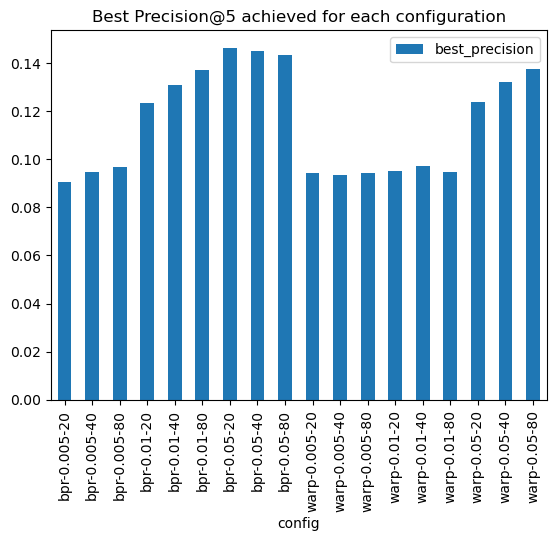

In [7]:
results_df = pd.DataFrame(results)
results_df['config'] = results_df['loss'] + '-' + results_df['learning_rate'].astype(str) + '-' + results_df['no_components'].astype(str)
results_df.plot(x='config', y='best_precision', kind='bar', title='Best Precision@5 achieved for each configuration')
plt.show()

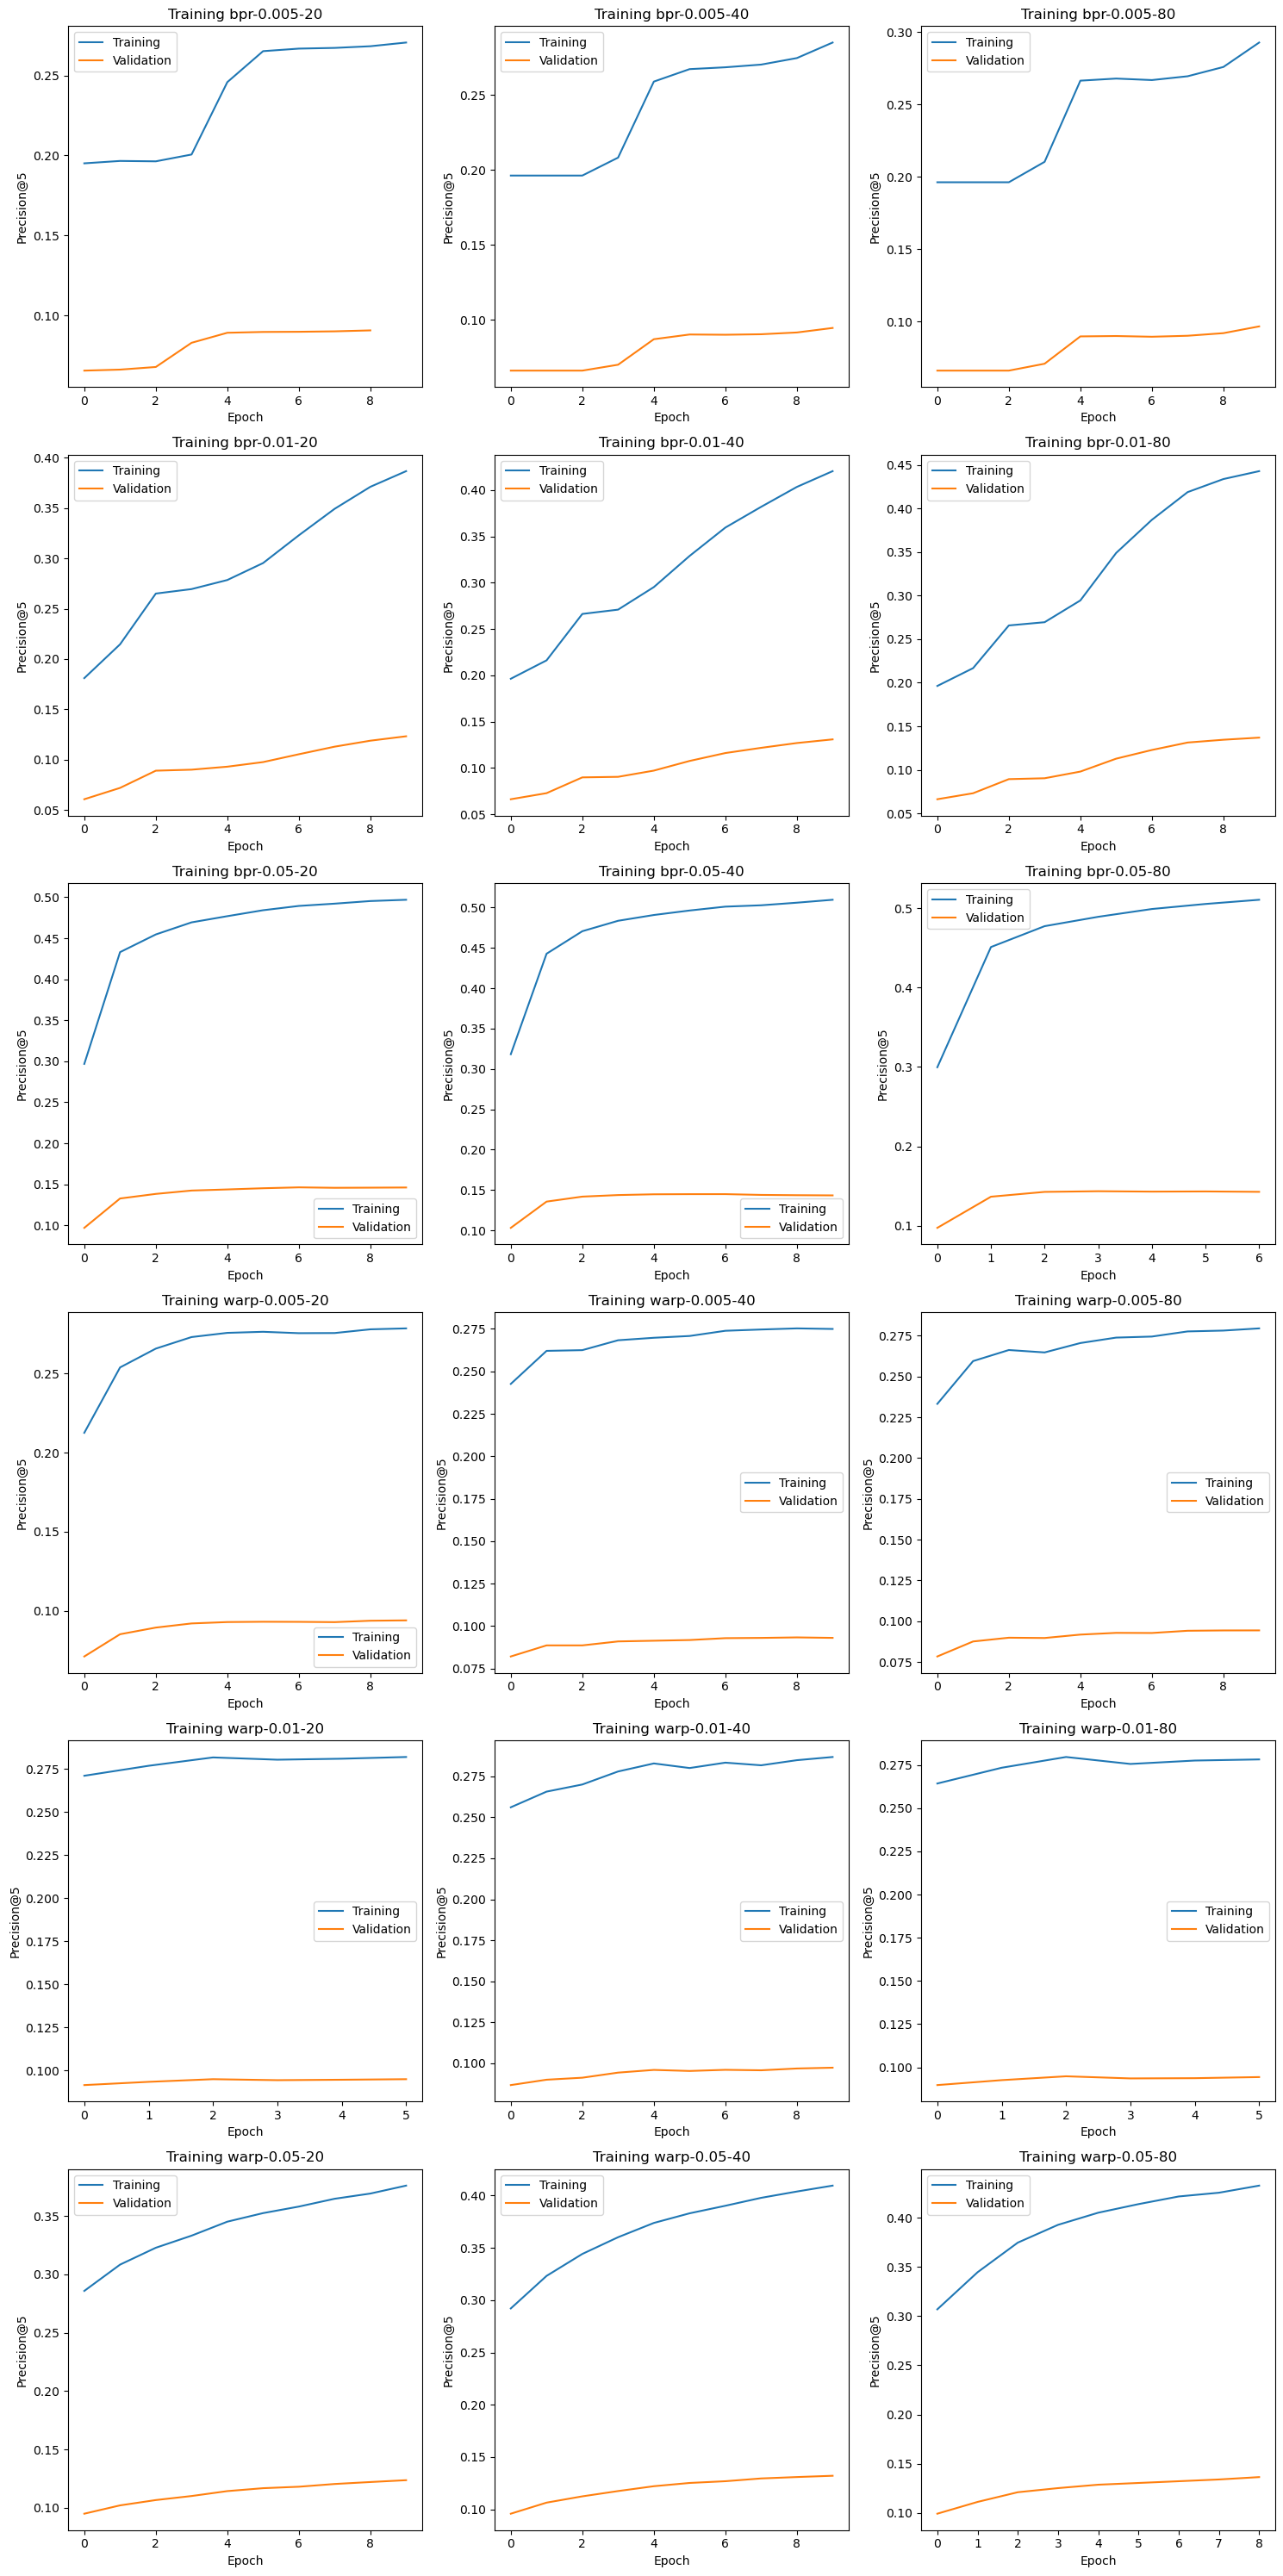

In [11]:
num_models = len(results)
rows = (num_models + 2) // 3
fig, axes = plt.subplots(rows, 3, figsize=(15, 5 * rows)) 
axes = axes.flatten()
for idx, (key, data) in enumerate(results.items()):
    ax = axes[idx]
    ax.plot(data['Training Precision@5'], label='Training')
    ax.plot(data['Validation Precision@5'], label='Validation')
    ax.set_title(key)
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Precision@5')
    ax.legend()
for ax in axes[num_models:]:
    ax.set_visible(False)
plt.tight_layout()
plt.show()

----------------------------------------------------------------------------------------------------------------
second grid search (precision@5 on validation set): <br> 
**lr**: 0.005 and 0.01 slow but consistent learning, 0.05 too big, fast but stuck around epoch 7<br>
**loss**: no big differences <br>
**num_factors**: overrall 80 better than 40, 40 better than 20<br>

| Epoch | bpr-0.005-20 | bpr-0.005-40 | bpr-0.005-80 | bpr-0.01-20 | bpr-0.01-40 | bpr-0.01-80 | bpr-0.05-20 | **<font color='red'>bpr-0.05-40</font>** | **<font color='red'>bpr-0.05-80</font>** | warp-0.005-20 | warp-0.005-40 | warp-0.005-80 | warp-0.01-20 | warp-0.01-40 | warp-0.01-80 | warp-0.05-20 | warp-0.05-40 | **<font color='red'>warp-0.05-80</font>** |
|-------|--------------|--------------|--------------|-------------|-------------|-------------|-------------|-------------|-------------|---------------|---------------|---------------|--------------|--------------|--------------|--------------|--------------|--------------|
| 1     | 0.07334      | 0.06564      | 0.06492      | 0.07138     | 0.06979     | 0.06704     | 0.14255     | 0.14217     | 0.15007     | 0.08981       | 0.09877       | 0.08570       | 0.10576      | 0.11303      | 0.11714      | 0.14055      | 0.15008      | 0.15699      |
| 2     | 0.07257      | 0.07283      | 0.06842      | 0.11511     | 0.11742     | 0.11734     | 0.16365     | 0.17381     | 0.18441     | 0.09128       | 0.10728       | 0.08856       | 0.11404      | 0.11930      | 0.12194      | 0.15229      | 0.16565      | 0.17466      |
| 3     | 0.09281      | 0.10968      | 0.10992      | 0.12171     | 0.12415     | 0.12572     | 0.17428     | 0.18576     | 0.19163     | 0.09378       | 0.11133       | 0.09270       | 0.11795      | 0.12392      | 0.12617      | 0.15849      | 0.17370      | 0.18210      |
| 4     | 0.11346      | 0.11789      | 0.11827      | 0.12806     | 0.13181     | 0.13659     | 0.18048     | 0.19008     | 0.19351     | 0.09557       | 0.11465       | 0.09889       | 0.12189      | 0.12627      | 0.13006      | 0.16284      | 0.17823      | 0.18610      |
| 5     | 0.11699      | 0.11909      | 0.12137      | 0.13499     | 0.13829     | 0.14303     | 0.18338     | 0.19136     | 0.19490     | 0.09756       | 0.11545       | 0.10438       | 0.12366      | 0.12662      | 0.13285      | 0.16630      | 0.18116      | 0.18933      |
| 6     | 0.11946      | 0.12154      | 0.12455      | 0.13841     | 0.14190     | 0.14919     | 0.18550     | 0.19257     | 0.19464     | 0.10105       | 0.11601       | 0.11064       | 0.12498      | 0.12858      | 0.13561      | 0.16854      | 0.18278      | 0.19080      |
| 7     | 0.12168      | 0.12393      | 0.12880      | 0.14193     | 0.14519     | 0.15380     | 0.18610     | 0.19284     | 0.19436     | 0.10412       | 0.11712       | 0.11625       | 0.12646      | 0.13046      | 0.13718      | 0.17046      | 0.18457      | 0.19217      |
| 8     | 0.12377      | 0.12726      | 0.13271      | 0.14462     | 0.14831     | 0.15855     | 0.18667     | 0.19263     | 0.19404     | 0.10533       | 0.11826       | 0.11887       | 0.12779      | 0.13264      | 0.13958      | 0.17236      | 0.18617      | 0.19238      |
| 9     | 0.12590      | 0.13027      | 0.13663      | 0.14635     | 0.15134     | 0.16282     | 0.18688     | 0.19199     | -     | 0.10787       | 0.11961       | 0.12160       | 0.12931      | 0.13381      | 0.14149      | 0.17375      | 0.18669      | 0.19324      |
| 10    | 0.12926      | 0.13307      | 0.13961      | 0.14828     | 0.15394     | 0.16661     | 0.18686     | 0.19159     | -     | 0.10931       | 0.12094       | 0.12195       | 0.12994      | 0.13461      | 0.14248      | 0.17467      | 0.18824      | 0.19404      |


Sources: [LightFM doc](https://making.lyst.com/lightfm/docs/home.html#:~:text=LightFM%20is%20a%20Python%20implementation,the%20traditional%20matrix%20factorization%20algorithms.) - [example](https://www.stepbystepdatascience.com/hybrid-recommender-lightfm-python) -[kaggle_ex1_](https://www.kaggle.com/code/parthplc/interview-building-recommendation-system-lightfm) - [kaggle_ex2](https://www.kaggle.com/code/niyamatalmass/lightfm-hybrid-recommendation-system) -[githubissue](https://github.com/lyst/lightfm/issues/229)

----------------------------------------------------------------------------------------------------------------------------------------
# HYBRID RS

In [2]:
import pandas as pd
import numpy as np
from tqdm import tqdm  
import json
import re

from lightfm import LightFM
from lightfm.data import Dataset
from lightfm.evaluation import precision_at_k

In [7]:
news_train = 'data/mind/MINDsmall_train/news.tsv'
news_test = 'data/mind/MINDsmall_dev/news.tsv'
train = pd.read_csv('data/train', sep='\t', header=0)
test = pd.read_csv('data/test', sep='\t', header=0)
val = pd.read_csv('data/val', sep='\t', header=0)

def load_df(path):
    if 'news' in path:
        columns = ['News ID',
                "Category",
                "SubCategory",
                "Title",
                "Abstract",
                "URL",
                "Title Entities",
                "Abstract Entities"]

    elif 'behavior' in path:
        columns = ['Impression ID',
                "User ID",
                "Time",
                "History",
                "Impressions"]
    else:
        return pd.read_csv(path, sep='\t', header=None)

    df = pd.read_csv(path, sep='\t', header=None, names=columns)
    return df
news_train, news_test = load_df(news_train), load_df(news_test)
data = pd.concat([news_train, news_test])

full = pd.concat([train, test, val]) #+1 min

In [ ]:
#preprocess data
data['News ID'] = data['News ID'].str[1:]
col = ['News ID', 'Category']
data = data[col]
data['News ID'] = data['News ID'].astype(int) 
full['item_id'] = full['item_id'].astype(int)
unique_newsid = data['News ID'].unique()
unique_itemid = full['item_id'].unique() #should be 27972
#check common news ID
common = np.intersect1d(unique_newsid, unique_itemid)
#print(len(common), len(unique_newsid), len(unique_itemid))
#keep in data only the one in common
data = data[data['News ID'].isin(common)]
#print(data.shape)
data = data.drop_duplicates(subset='News ID') #since it is made of both train and test
#print(data.shape)
#print distribution of category in da
data['Category'].value_counts()
#change category with less than 5 instances
data['Category'] = data['Category'].apply(lambda x: 'news' if x == 'northamerica' else x)
data['Category'] = data['Category'].apply(lambda x: 'news' if x == 'middleeast' else x)
data['Category'] = data['Category'].apply(lambda x: 'lifestyle' if x == 'kids' else x)
data = data.rename(columns={'News ID': 'item_id', 'Category': 'category'})

In [ ]:
categories = ['autos', 'entertainment', 'finance', 'foodanddrink', 'health',
              'lifestyle', 'movies', 'music', 'news', 'sports', 'travel', 'tv',
              'video', 'weather']
data_hybrid = pd.get_dummies(data, columns=['category'], prefix='category')

#convert bool to 0 or 1
data_hybrid = data_hybrid.astype(int)
data_hybrid
item_features_list = []

for index, row in data_hybrid.iterrows():
    item_id = row['item_id']
    features = {col: row[col] for col in data_hybrid.columns if col.startswith('category_')}
    item_features_list.append((item_id, features))

In [ ]:
dataset = Dataset(item_identity_features=True) 
dataset.fit_partial(
    users = full['user_id'].unique(),
    items = full['item_id'].unique(),
    item_features = list(data_hybrid.columns)
)

(interactions_train, weights_train) = dataset.build_interactions([(x[1], x[2], x[3]) for x in train.itertuples()]) #x[0] is the row-index
(interactions_val, weights_test) = dataset.build_interactions([(x[1], x[2], x[3]) for x in val.itertuples()])

item_features = dataset.build_item_features(item_features_list, normalize=True)
[dataset_user_id_mapping,
 dataset_user_feature_mapping,
 dataset_item_id_mapping,
 dataset_item_feature_mapping] = dataset.mapping()


In [ ]:
print(f"user_id_mapping: {len(dataset_user_id_mapping)}, user_feature_mapping: {len(dataset_user_feature_mapping)}, item_id_mapping: {len(dataset_item_id_mapping)}, item_feature_mapping: {len(dataset_item_feature_mapping)}")

In [ ]:
import joblib

learning_rates = [0.01, 0.05]       #grid search
no_components = [20, 40, 80, 100]
loss_functions = ['bpr', 'warp']
max_sampled = 3

epochs = 10
patience = 3
k = 5

best_params = {}
best_val_precision = 0
best_epoch = 0


results = {}

    
for loss in loss_functions:
    for learning_rate in learning_rates:
        for no_component in no_components:
            config_key = f'Training {loss}-{learning_rate}-{no_component}'
            results[config_key] = {'Training Precision@5': [], 'Validation Precision@5': []}
            
            
            model = LightFM(loss=loss, learning_rate=learning_rate, no_components=no_component, max_sampled=max_sampled, random_state=42)
            patience_counter = 0
            local_best_precision = 0

            for epoch in tqdm(range(epochs), desc=f'Training {loss}-{learning_rate}-{no_component}'):
                model.fit_partial(interactions_train, epochs=1, num_threads=4)
                train_precision = precision_at_k(model, interactions_train, k=k).mean()
                val_precision = precision_at_k(model, interactions_val, k=k).mean()
                
                results[config_key]['Training Precision@5'].append(train_precision)
                results[config_key]['Validation Precision@5'].append(val_precision)
                    
                print(f'Epoch {epoch + 1}/{epochs} for config {loss}-{learning_rate}-{no_component}')
                print(f'Training Precision@{k}: {train_precision} | Validation Precision@{k}: {val_precision}')

                if val_precision > local_best_precision:
                    local_best_precision = val_precision                        
                    patience_counter = 0
                    if val_precision > best_val_precision:
                        best_val_precision = val_precision
                        best_params = {'loss': loss, 'learning_rate': learning_rate, 'no_components': no_component}
                        best_epoch = epoch + 1
                            
                        model_filename = f'data/best_model/hybrid_best_model_{loss}_{learning_rate}_{no_component}.pkl'
                        joblib.dump(model, model_filename)
                        print(f'Saved new best model for config {loss}-{learning_rate}-{no_component} at epoch {epoch + 1}')
                else:
                    patience_counter += 1

                if patience_counter >= patience:
                    print(f'Early stopping for config {loss}-{learning_rate}-{no_component} at epoch {epoch + 1}')
                    break
                

print(f'Best validation precision achieved with config {best_params} at epoch {best_epoch}: {best_val_precision}')
print('All results:', results)

In [ ]:
data = []
for config, metrics in results.items():
    for epoch in range(len(metrics['Training Precision@5'])):
        data.append({
            'Configuration': config,
            'Epoch': epoch + 1,
            'Training Precision@5': metrics['Training Precision@5'][epoch],
            'Validation Precision@5': metrics['Validation Precision@5'][epoch]
        })

res = pd.DataFrame(data)
res.to_csv('data/hybrid_results.csv', index=False)

<Axes: title={'center': 'Best Precision@5 achieved for each configuration'}, xlabel='Configuration'>

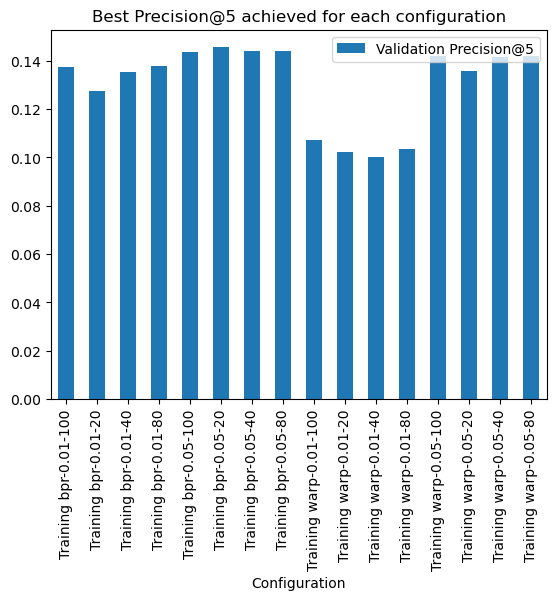

In [6]:
results_df = pd.read_csv('res/hybrid_results.csv')
res = results_df.groupby('Configuration').agg({'Validation Precision@5': 'max'}).reset_index()
#plot
res.plot(x='Configuration', y='Validation Precision@5', kind='bar', title='Best Precision@5 achieved for each configuration')

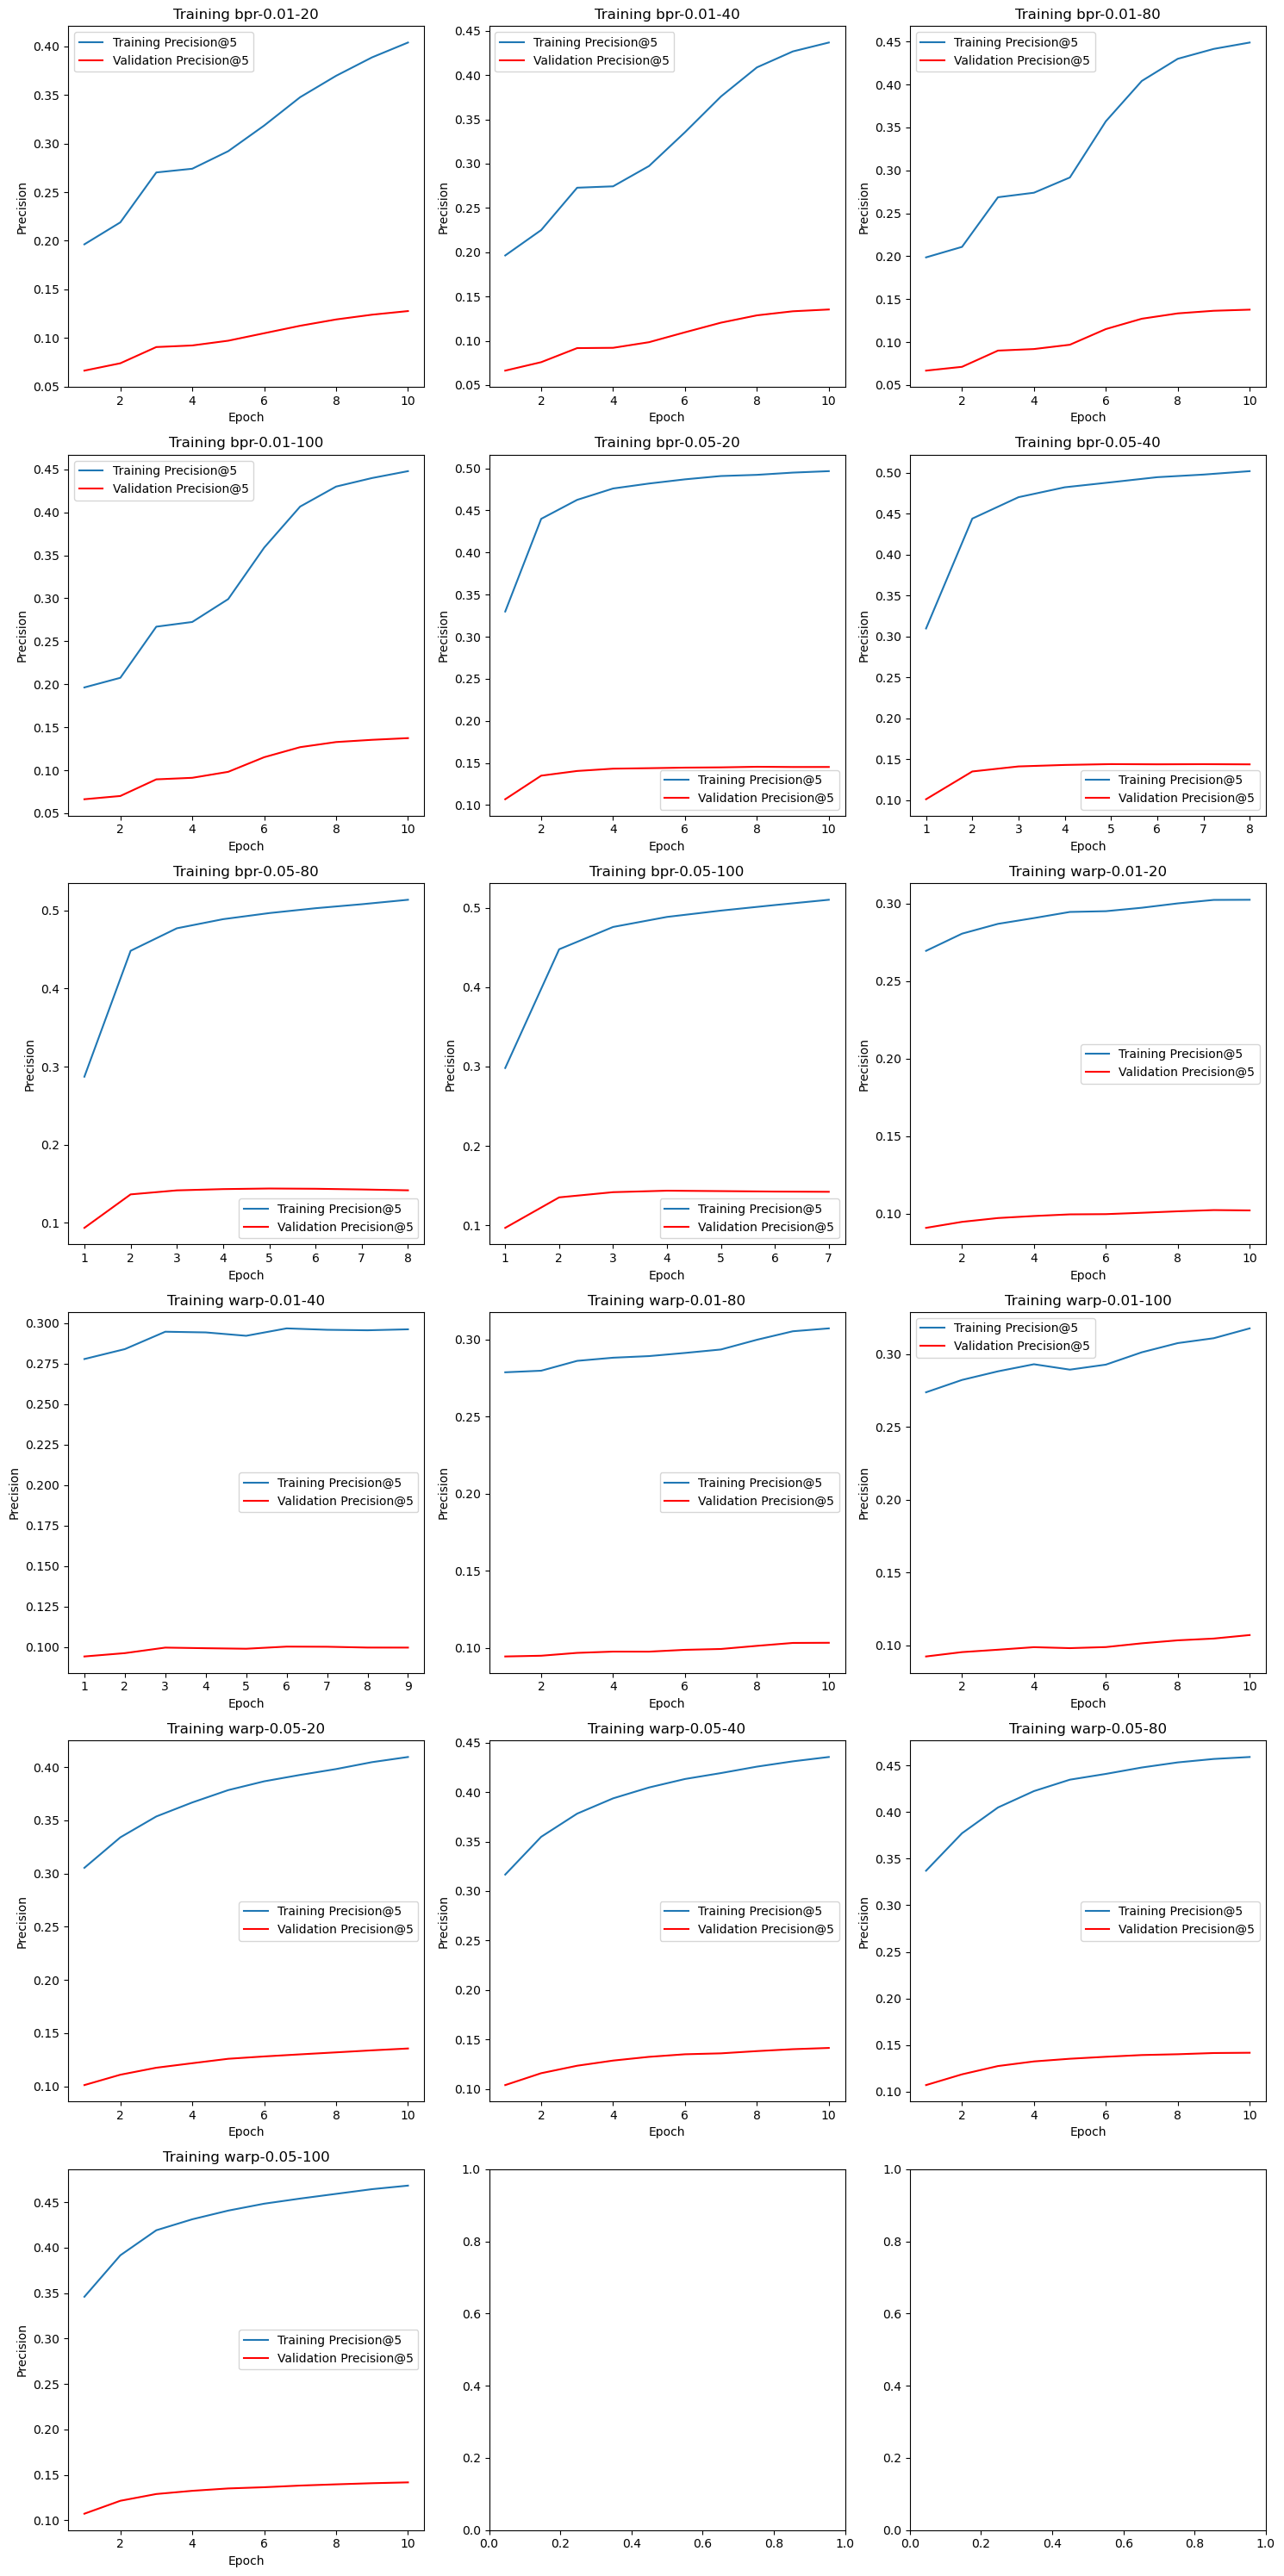

In [4]:
unique_configs = results_df['Configuration'].unique()
num_models = len(unique_configs)
rows = (num_models + 2) // 3
fig, axes = plt.subplots(rows, 3, figsize=(15, 5 * rows)) 
axs = axes.flatten()
for i, config in enumerate(unique_configs):
    config_data = results_df[results_df['Configuration'] == config]
    axs[i].plot(config_data['Epoch'], config_data['Training Precision@5'], label='Training Precision@5', )
    axs[i].plot(config_data['Epoch'], config_data['Validation Precision@5'], label='Validation Precision@5', color='r', )
    
    axs[i].set_title(f'{config}')
    axs[i].set_xlabel('Epoch')
    axs[i].set_ylabel('Precision')
    axs[i].legend()
plt.tight_layout()
plt.show()


# Pure CF vs Hybrid

In [12]:
import matplotlib.pyplot as plt
import numpy as np
cf_res = pd.read_csv('res/results_cb.csv')
hyb_res = pd.read_csv('res/hybrid_results.csv')
common_configs = np.intersect1d(cf_res['Configuration'], hyb_res['Configuration'])


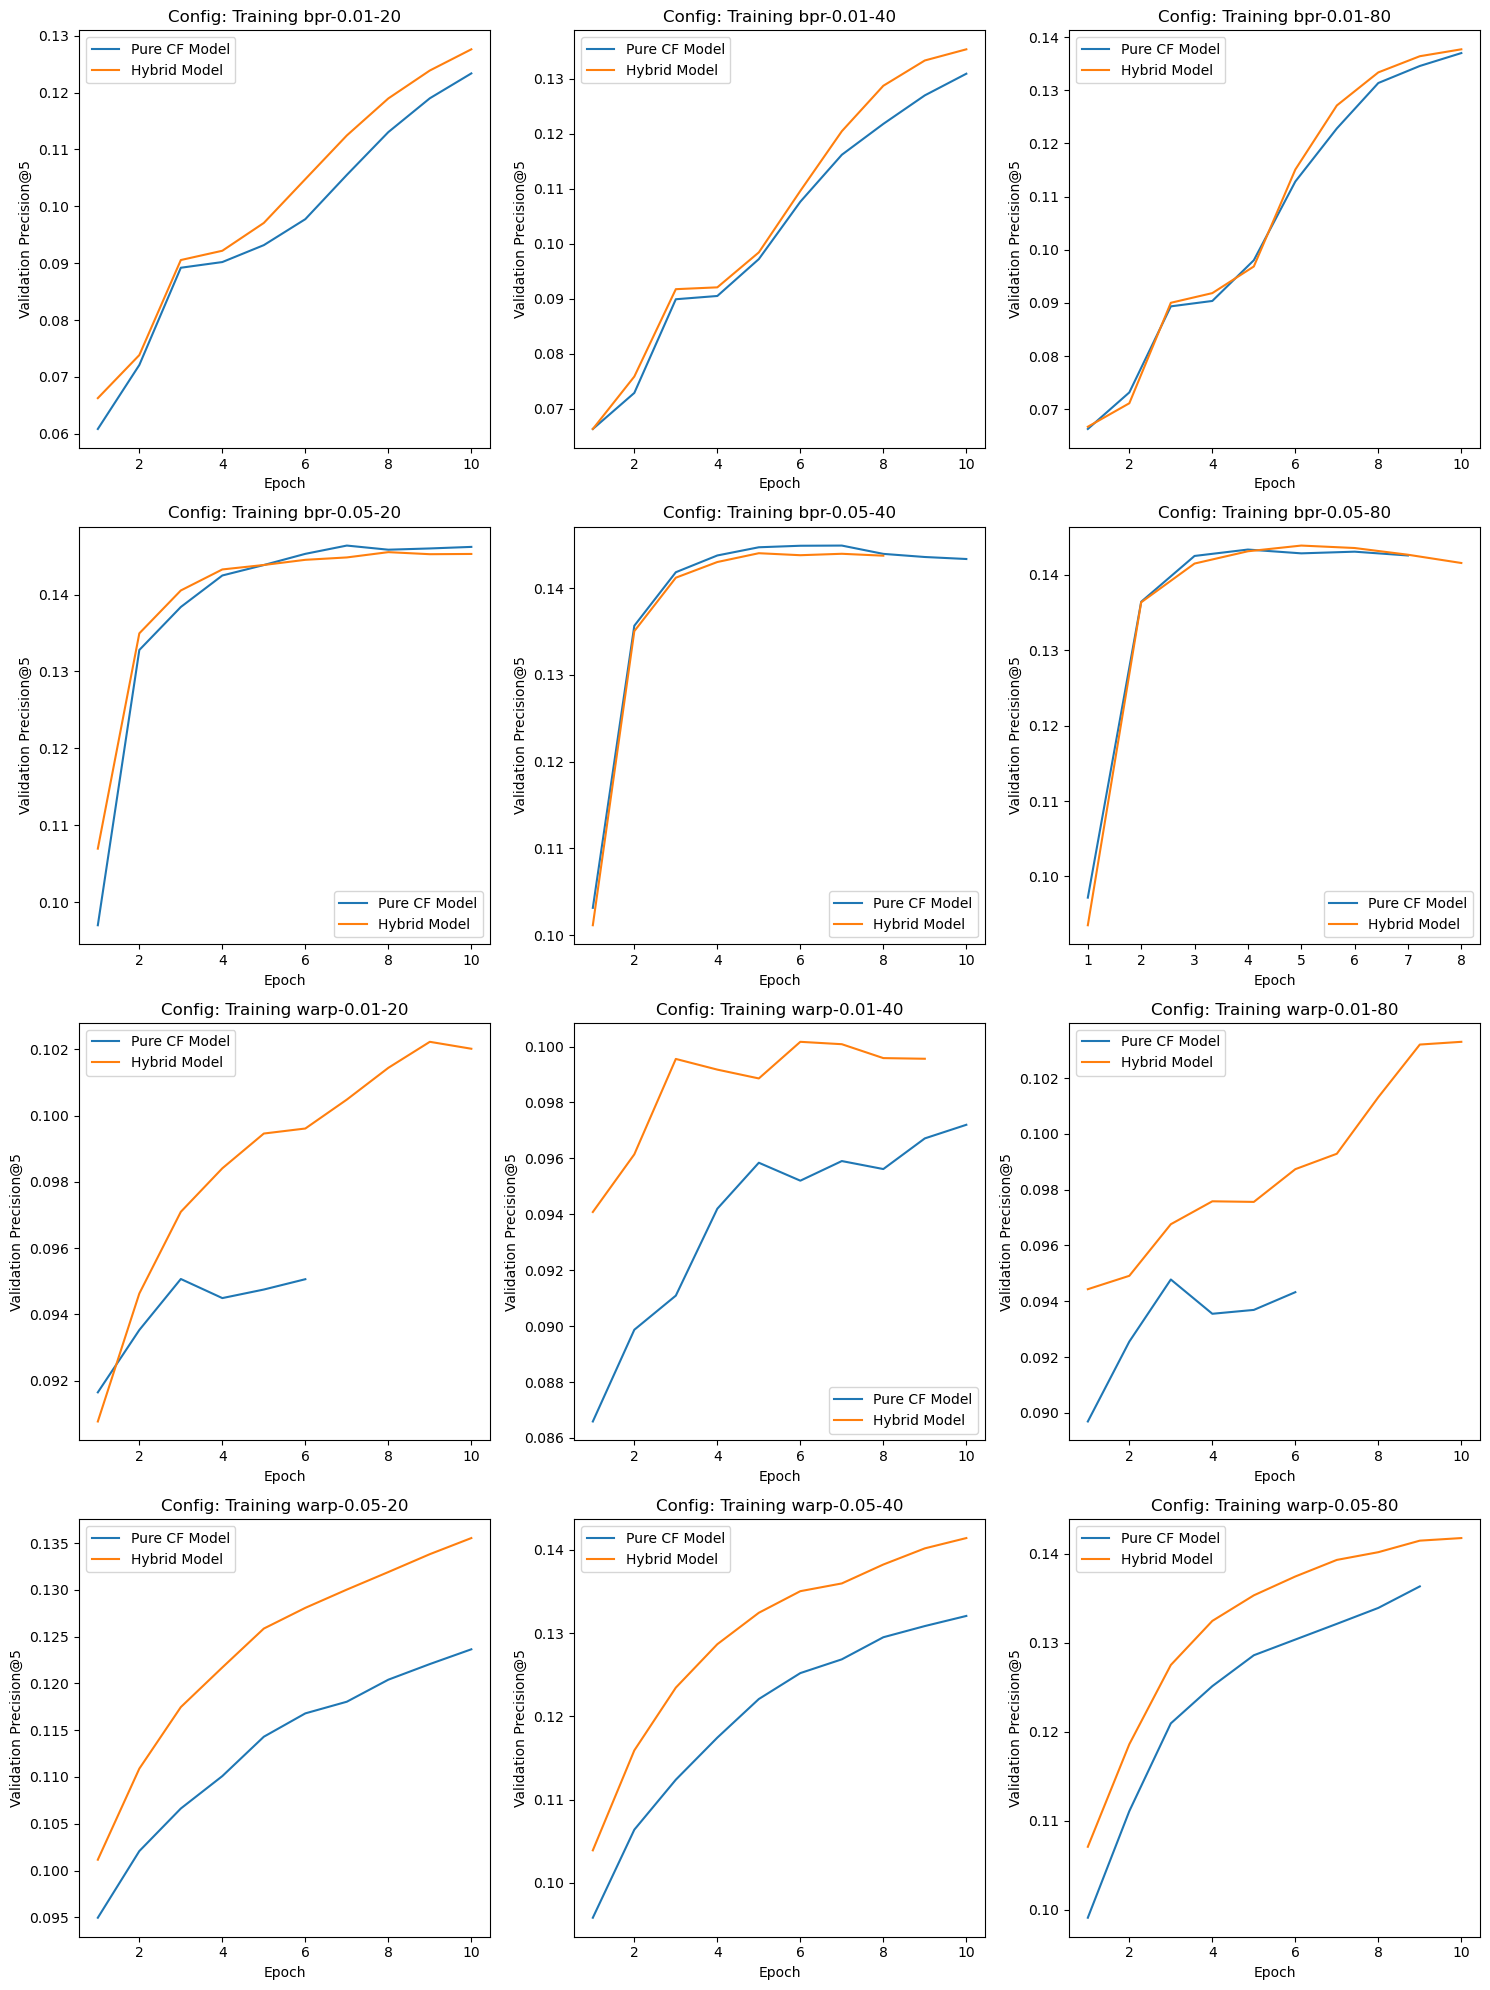

In [15]:
num_plots_per_row = 3
num_rows = (len(common_configs) + num_plots_per_row - 1) // num_plots_per_row
plt.figure(figsize=(5 * num_plots_per_row, 5 * num_rows))

for index, config in enumerate(common_configs):
    plt.subplot(num_rows, num_plots_per_row, index + 1)
    config_data_cf = cf_res[cf_res['Configuration'] == config]
    config_data_hyb = hyb_res[hyb_res['Configuration'] == config]

    plt.plot(config_data_cf['Epoch'], config_data_cf['Validation Precision@5'], label='Pure CF Model')
    plt.plot(config_data_hyb['Epoch'], config_data_hyb['Validation Precision@5'], label='Hybrid Model')
    plt.title(f'Config: {config}')
    plt.xlabel('Epoch')
    plt.ylabel('Validation Precision@5')
    plt.legend()
plt.tight_layout()
plt.show()